In [2]:
import gym
import sys
import numpy as np

from gym import error, spaces, utils
from copy import deepcopy

import matplotlib.pyplot as plt
import collections

from tqdm import tqdm

In [310]:
class CliffWalkingEnv(gym.Env):
    """
    A simplified implementation of the cliffwalking environment from 
    Sutton & Barto (e.g., Figure 6.13)

    The board is a 4x12 matrix, with (using NumPy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    """

    def observation(self, state):
        return state[0] * self.cols + state[1]

    def __init__(self, render_steps = False):
        self.env_shape = (4, 12) # attributes like these are added for convenience
        # (i.e., so it's easy to refer to these values in various methods)
        self.rows = 4
        self.cols = 12
        self.start = [3,0] # row, col of our start position
        self.goal = [3,11] # row, col of our terminal state
        self.current_state = self.start 
        self.render_steps = render_steps

        # Cliff location
        self._cliff = np.zeros(self.env_shape, dtype=np.bool)
        self._cliff[3, 1:-1] = True 

        # There are four actions: up, down, left and right
        # Note that the state space gym.spaces.Discrete is a custom class
        # in the gym library.
        self.action_space = spaces.Discrete(4)

        # observation is the x, y coordinate of the grid
        # Note the state space is the same custom class.
        self.observation_space = spaces.Discrete(self.rows*self.cols)


    def step(self, action):
        """
        Take a step in the cliffwalking environment.

        INPUT
          action : integer (0,3) : right (0), down (1), left (2), and up (3).
        OUTPUT
          observation : A special class representing the x,y on the grid.
          reward : float : The reward received following the action.
          terminal_state : boolean : Has the terminal state been reached?
        """
        new_state = deepcopy(self.current_state)

        if action == 0: #right, "min" ensures you can't go through a wall,
          # and just end up back in your previous state.
            new_state[1] = min(new_state[1]+1, self.cols-1)
        elif action == 1: #down, "max" ensures you can't go through a wall.
            new_state[0] = max(new_state[0]-1, 0)
        elif action == 2: #left
            new_state[1] = max(new_state[1]-1, 0)
        elif action == 3: #up
            new_state[0] = min(new_state[0]+1, self.rows-1)
        else:
            raise Exception("Invalid action.")

        # Update our state
        self.current_state = new_state

        if self.render_steps:
          self.render()

        reward = -1.0
        terminal_state = False
        if self.current_state[0] == 3 and self.current_state[1] > 0:
            if self.current_state[1] < self.cols - 1:
                reward = -100.0
                self.current_state = deepcopy(self.start)
            else:
                terminal_state = True

        # IMPORTANT: The step() method needs to return these 4 things in this order.
        # The new state, the reward, "is this episode over?" boolean", 
        # and an "info dictionary" for debugging purposes if you want to use it. 
        # I leave it empty.  
        return self.observation(self.current_state), reward, terminal_state, {}

    def reset(self):
        self.current_state = self.start
        return self.observation(self.current_state)
    
    def show_env(self):
      """
      Shows the environment.
      """
      gridworld = np.ndarray((self.rows,self.cols), dtype = 'object')

      for row in np.arange(self.rows):
        for col in np.arange(self.cols):

          if self.current_state == [row,col]:
            gridworld[row,col] = "x"
          elif [row,col] == self.goal:
              gridworld[row,col] = "T"
          elif self._cliff[row,col]:
              gridworld[row,col] = "C"
          else:
              gridworld[row,col] = "o"

      print(gridworld)


    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
      """
      render function from:
      https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py

      I admit I don't have much experience with rendering with characters. On face,
      this works the same as what I made.
      """
      if close:
        return

      outfile = StringIO() if mode == 'ansi' else sys.stdout

      for s in range(self.rows*self.cols):
            position = np.unravel_index(s, self.env_shape)
            # print(self.s)
            if self.current_state == s:
                output = " x "
            elif position == (3,11):
                output = " T "
            elif self._cliff[position]:
                output = " C "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip() 
            if position[1] == self.env_shape[1] - 1:
                output = output.rstrip() 
                output += "\n"

            outfile.write(output)
      outfile.write("\n")

    def close(self):
        pass

In [5]:
from contextlib import closing
from io import StringIO
from os import path
from typing import Optional
import pygame
from pygame.constants import SRCALPHA
import numpy as np

from gym import Env, spaces, utils
from gym.envs.toy_text.utils import categorical_sample

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": ["SFFF", "FHFH", "FFFH", "HFFG"],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG",
    ],
}


def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == "G":
                        return True
                    if res[r_new][c_new] != "H":
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(["F", "H"], (size, size), p=[p, 1 - p])
        res[0][0] = "S"
        res[-1][-1] = "G"
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(Env):
    """
    Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H) by walking over
    the Frozen(F) lake. The agent may not always move in the intended direction due to the slippery nature of the frozen lake.
    ### Action Space
    The agent takes a 1-element vector for actions.
    The action space is `(dir)`, where `dir` decides direction to move in which can be:
    - 0: LEFT
    - 1: DOWN
    - 2: RIGHT
    - 3: UP
    ### Observation Space
    The observation is a value representing the agent's current position as
    current_row * nrows + current_col (where both the row and col start at 0).
    For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15.
    The number of possible observations is dependent on the size of the map.
    For example, the 4x4 map has 16 possible observations.
    ### Rewards
    Reward schedule:
    - Reach goal(G): +1
    - Reach hole(H): 0
    - Reach frozen(F): 0
    ### Arguments
    ```
    gym.make('FrozenLake-v1', desc=None,map_name="4x4", is_slippery=True)
    ```
    `desc`: Used to specify custom map for frozen lake. For example,
        desc=["SFFF", "FHFH", "FFFH", "HFFG"].
    `map_name`: ID to use any of the preloaded maps.
        "4x4":[
            "SFFF",
            "FHFH",
            "FFFH",
            "HFFG"
            ]
        "8x8": [
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG",
        ]
    `is_slippery`: True/False. If True will move in intended direction with
    probability of 1/3 else will move in either perpendicular direction with
    equal probability of 1/3 in both directions.
        For example, if action is left and is_slippery is True, then:
        - P(move left)=1/3
        - P(move up)=1/3
        - P(move down)=1/3
    ### Version History
    * v1: Bug fixes to rewards
    * v0: Initial versions release (1.0.0)
    """

    metadata = {"render.modes": ["human", "ansi", "rgb_array"]}

    def __init__(self, desc=None, map_name="4x4", is_slippery=True):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        self.initial_state_distrib = np.array(desc == b"S").astype("float64").ravel()
        self.initial_state_distrib /= self.initial_state_distrib.sum()

        self.P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            done = bytes(newletter) in b"GH"
            reward = float(newletter == b"G")
            return newstate, reward, done

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = self.P[s][a]
                    letter = desc[row, col]
                    if letter in b"GH":
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                li.append(
                                    (1.0 / 3.0, *update_probability_matrix(row, col, b))
                                )
                        else:
                            li.append((1.0, *update_probability_matrix(row, col, a)))

        self.observation_space = spaces.Discrete(nS)
        self.action_space = spaces.Discrete(nA)

        # pygame utils
        self.window_size = (min(64 * ncol, 512), min(64 * nrow, 512))
        self.window_surface = None
        self.hole_img = None
        self.cracked_hole_img = None
        self.ice_img = None
        self.elf_images = None
        self.goal_img = None
        self.start_img = None

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, d = transitions[i]
        self.s = s
        self.lastaction = a
        return (int(s), r, d, {"prob": p})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        return_info: bool = False,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None

        if not return_info:
            return int(self.s)
        else:
            return int(self.s), {"prob": 1}

    def render(self, mode="human"):
        desc = self.desc.tolist()
        if mode == "ansi":
            return self._render_text(desc)
        else:
            return self._render_gui(desc, mode)

    def _render_gui(self, desc, mode):
        if self.window_surface is None:
            pygame.init()
            pygame.display.set_caption("Frozen Lake")
            if mode == "human":
                self.window_surface = pygame.display.set_mode(self.window_size)
            else:  # rgb_array
                self.window_surface = pygame.Surface(self.window_size)
        if self.hole_img is None:
            file_name = path.join(path.dirname(__file__), "img/hole.png")
            self.hole_img = pygame.image.load(file_name)
        if self.cracked_hole_img is None:
            file_name = path.join(path.dirname(__file__), "img/cracked_hole.png")
            self.cracked_hole_img = pygame.image.load(file_name)
        if self.ice_img is None:
            file_name = path.join(path.dirname(__file__), "img/ice.png")
            self.ice_img = pygame.image.load(file_name)
        if self.goal_img is None:
            file_name = path.join(path.dirname(__file__), "img/goal.png")
            self.goal_img = pygame.image.load(file_name)
        if self.start_img is None:
            file_name = path.join(path.dirname(__file__), "img/stool.png")
            self.start_img = pygame.image.load(file_name)
        if self.elf_images is None:
            elfs = [
                path.join(path.dirname(__file__), "img/elf_left.png"),
                path.join(path.dirname(__file__), "img/elf_down.png"),
                path.join(path.dirname(__file__), "img/elf_right.png"),
                path.join(path.dirname(__file__), "img/elf_up.png"),
            ]
            self.elf_images = [pygame.image.load(f_name) for f_name in elfs]

        board = pygame.Surface(self.window_size, flags=SRCALPHA)
        cell_width = self.window_size[0] // self.ncol
        cell_height = self.window_size[1] // self.nrow
        smaller_cell_scale = 0.6
        small_cell_w = smaller_cell_scale * cell_width
        small_cell_h = smaller_cell_scale * cell_height

        # prepare images
        last_action = self.lastaction if self.lastaction is not None else 1
        elf_img = self.elf_images[last_action]
        elf_scale = min(
            small_cell_w / elf_img.get_width(),
            small_cell_h / elf_img.get_height(),
        )
        elf_dims = (
            elf_img.get_width() * elf_scale,
            elf_img.get_height() * elf_scale,
        )
        elf_img = pygame.transform.scale(elf_img, elf_dims)
        hole_img = pygame.transform.scale(self.hole_img, (cell_width, cell_height))
        cracked_hole_img = pygame.transform.scale(
            self.cracked_hole_img, (cell_width, cell_height)
        )
        ice_img = pygame.transform.scale(self.ice_img, (cell_width, cell_height))
        goal_img = pygame.transform.scale(self.goal_img, (cell_width, cell_height))
        start_img = pygame.transform.scale(self.start_img, (small_cell_w, small_cell_h))

        for y in range(self.nrow):
            for x in range(self.ncol):
                rect = (x * cell_width, y * cell_height, cell_width, cell_height)
                if desc[y][x] == b"H":
                    self.window_surface.blit(hole_img, (rect[0], rect[1]))
                elif desc[y][x] == b"G":
                    self.window_surface.blit(ice_img, (rect[0], rect[1]))
                    goal_rect = self._center_small_rect(rect, goal_img.get_size())
                    self.window_surface.blit(goal_img, goal_rect)
                elif desc[y][x] == b"S":
                    self.window_surface.blit(ice_img, (rect[0], rect[1]))
                    stool_rect = self._center_small_rect(rect, start_img.get_size())
                    self.window_surface.blit(start_img, stool_rect)
                else:
                    self.window_surface.blit(ice_img, (rect[0], rect[1]))

                pygame.draw.rect(board, (180, 200, 230), rect, 1)

        # paint the elf
        bot_row, bot_col = self.s // self.ncol, self.s % self.ncol
        cell_rect = (
            bot_col * cell_width,
            bot_row * cell_height,
            cell_width,
            cell_height,
        )
        if desc[bot_row][bot_col] == b"H":
            self.window_surface.blit(cracked_hole_img, (cell_rect[0], cell_rect[1]))
        else:
            elf_rect = self._center_small_rect(cell_rect, elf_img.get_size())
            self.window_surface.blit(elf_img, elf_rect)

        self.window_surface.blit(board, board.get_rect())
        if mode == "human":
            pygame.display.update()
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window_surface)), axes=(1, 0, 2)
            )

    @staticmethod
    def _center_small_rect(big_rect, small_dims):
        offset_w = (big_rect[2] - small_dims[0]) / 2
        offset_h = (big_rect[3] - small_dims[1]) / 2
        return (
            big_rect[0] + offset_w,
            big_rect[1] + offset_h,
        )

    def _render_text(self, desc):
        outfile = StringIO()

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(f"  ({['Left', 'Down', 'Right', 'Up'][self.lastaction]})\n")
        else:
            outfile.write("\n")
        outfile.write("\n".join("".join(line) for line in desc) + "\n")

        with closing(outfile):
            return outfile.getvalue()


# Elf and stool from https://franuka.itch.io/rpg-snow-tileset
# All other assets by Mel Sawyer

pygame 2.1.2 (SDL 2.0.18, Python 3.8.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [51]:
class Q_learning_agent(object):
    def __init__(self, obs_n, act_n = 4, learning_rate=0.01, gamma=0.9, e_greed=0.1):
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = e_greed
        self.act_n = act_n
        self.Q = np.zeros((obs_n, act_n))
        self.lr_min = 1e-5
        
        info = "Q_LearningAgent with state number = " +  str(obs_n) + ", learning rate = " + str(learning_rate) + ", gamma = " + str(gamma) + " created."
        print(info)
    
    def policy(self, S):
        if np.random.uniform(0, 1) < (1.0 - self.epsilon):
            action = self.predict(S)
        else:
            action = np.random.choice(self.act_n)

        return action

    def predict(self, S):
        Q_values = self.Q[S]
        maxQ = np.max(self.Q[S])

        action = np.random.choice(np.where(Q_values == maxQ)[0])
        return action
        
    def learn(self, S, action, reward, S_prime, action_prime, done):
        predit_Q = self.Q[S, action]

        if (done):
            target_Q = reward
        else:
            target_Q = reward + self.gamma * np.max(self.Q[S_prime])

        self.Q[S, action] += self.lr * (target_Q - predit_Q)
    
    def decay(self, epsilon_decay_rate, lr_decay_rate):
        self.epsilon *= (1 - epsilon_decay_rate)
        self.lr = max(self.lr_min, self.lr * (1 - lr_decay_rate))

In [312]:
class SarsaAgent(object):
    def __init__(self, obs_n, act_n = 4, learning_rate=0.01, gamma=0.9, e_greed=0.1):
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = e_greed
        self.act_n = act_n
        self.Q = np.zeros((obs_n, act_n))
        
        info = "Sarsa Agent with state number = " +  str(obs_n) + ", learning rate = " + str(learning_rate) + ", gamma = " + str(gamma) + " created."
        print(info)

    def policy(self, S):
        if np.random.uniform(0, 1) < (1.0 - self.epsilon):
            action = self.predict(S)
        else:
            action = np.random.choice(self.act_n)

        return action

    def predict(self, S):
        Q_values = self.Q[S]
        maxQ = np.max(self.Q[S])

        action = np.random.choice(np.where(Q_values == maxQ)[0])
        return action

    def learn(self, S, action, reward, S_prime, action_prime, done):
        predit_Q = self.Q[S, action]

        if (done):
            target_Q = reward
        else:
            target_Q = reward + self.gamma * self.Q[S_prime, action_prime]

        self.Q[S, action] += self.lr * (target_Q - predit_Q)
    

In [313]:
def run_episode(env, agent):
    S = env.reset()
    action = agent.policy(S)
    
    total_reward = 0
    while (True):
        S_prime, reward, done, _ = env.step(action)
        action_prime = agent.policy(S_prime)

        agent.learn(S, action, reward, S_prime, action_prime, done)

        action = action_prime
        S = S_prime
        total_reward += reward

        if done:
            break
    
    return total_reward

In [314]:
def main():
    env = CliffWalkingEnv()

    q_agent = Q_learning_agent(obs_n=env.observation_space.n,  act_n=env.action_space.n, 
        learning_rate=0.5, gamma = 1, e_greed=0.1)

    sarsa_agent = SarsaAgent(obs_n=env.observation_space.n,  act_n=env.action_space.n, 
        learning_rate=0.5, gamma = 1, e_greed=0.1)

    q_reward_history = []
    sarsa_reward_history = []

    for i in range(20):
        q_reward_list = []
        sarsa_reward_list = []

        for episode in range(500):
            q_reward = run_episode(env, q_agent)
            q_reward_list.append(q_reward)

            sarsa_reward = run_episode(env, sarsa_agent)
            sarsa_reward_list.append(sarsa_reward)

        q_reward_history.append(q_reward_list)
        sarsa_reward_history.append(sarsa_reward_list)

    q_reward_history = np.array(q_reward_history)
    sarsa_reward_history = np.array(sarsa_reward_history)

    q_avg = q_reward_history.sum(axis=0)/20
    sarsa_avg = sarsa_reward_history.sum(axis=0)/20

    return q_avg, sarsa_avg

In [315]:
q_avg, sarsa_avg = main()

Q_LearningAgent with state number = 48, learning rate = 0.5, gamma = 1 created.
Sarsa Agent with state number = 48, learning rate = 0.5, gamma = 1 created.


In [316]:
q_avg_rewards = []
sarsa_avg_rewards = []
for i in range(14):
    q_avg_rewards.append(np.mean(q_avg[:i+1]))
    sarsa_avg_rewards.append(np.mean(sarsa_avg[:i+1]))
for i in range(15,len(q_avg)+1):
    q_avg_rewards.append(np.mean(q_avg[i-15:i]))
    sarsa_avg_rewards.append(np.mean(sarsa_avg[i-15:i]))


Text(0, 0.5, 'Sum of rewards during episode')

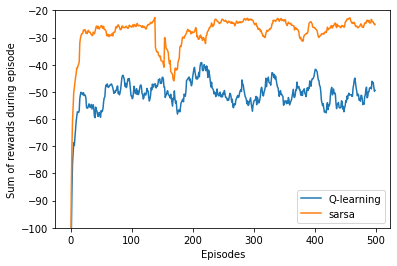

In [317]:
plt.plot(range(0,500), q_avg_rewards, label="Q-learning")
plt.plot(range(0,500), sarsa_avg_rewards,label="sarsa")
plt.ylim((-100,-20))
plt.legend(loc="lower right")
plt.xlabel("Episodes")
plt.ylabel("Sum of rewards during episode")

In [318]:
class monte_carlo_agent(object):
    def __init__(self, obs_n, act_n, gamma, epsilon):
        self.gamma = gamma
        self.epsilon = epsilon
        self.act_n = act_n
        self.Q = np.zeros((obs_n, act_n))

    def policy(self, S):
        if np.random.uniform(0, 1) < (1.0 - self.epsilon):
            action = self.predict(S)
        else:
            action = np.random.choice(self.act_n)

        return action

    def predict(self, S):
        Q_values = self.Q[S]
        maxQ = np.max(self.Q[S])

        action = np.random.choice(np.where(Q_values == maxQ)[0])
        return action

    def learn(self, total_returns, num_visits, state, action):
        self.Q[state, action] = total_returns[state, action] / num_visits[state]
    
        

In [319]:
def monte_carlo():
    env = CliffWalkingEnv()
    mc_agent = monte_carlo_agent(obs_n=env.observation_space.n,  act_n=env.action_space.n,  gamma = 1, epsilon=0.1)
    gamma = 0.8

    rewards_list = []
    total_returns = np.zeros((env.observation_space.n, env.action_space.n))
    num_visits = np.zeros(env.observation_space.n)

    for episode in range(500):
        trajectory = []
        S = env.reset()
        print(episode)
        action = mc_agent.policy(S)

        total_reward = 0
        while(True):
            S_prime, reward, done, _ = env.step(action)
            trajectory.append((S, action, reward))
            action_prime = mc_agent.policy(S_prime)

            S = S_prime
            action = action_prime
            total_reward += reward 
            if done:
                break
        
        rewards_list.append(total_reward)
        previous_reward = 0
        for state, action, reward in trajectory:
            total_returns[state, action] += (reward + gamma * previous_reward)
            num_visits[state] += 1
            mc_agent.learn(total_returns, num_visits, state, action)


    return rewards_list

In [ ]:
rewards_list = monte_carlo()

In [ ]:
mc_rewards = []
for i in range(14):
    mc_rewards.append(np.mean(rewards_list[:i+1]))

for i in range(15,len(q_avg)+1):
    mc_rewards.append(np.mean(rewards_list[i - 15:]))


(-100.0, 0.0)

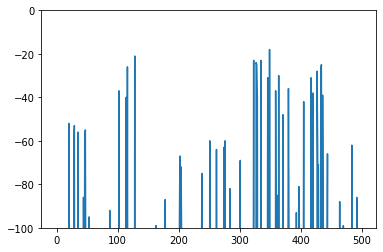

In [ ]:
plt.plot(range(0,500), rewards_list)
plt.ylim((-100,0))

In [3]:
frozenv = gym.make("FrozenLake-v0")

In [43]:
class exp_sarsa_agent(object):
    def __init__(self, obs_n = 16, act_n = 4, learning_rate=0.3, gamma=0.98, e_greed=0.1):
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = e_greed
        self.act_n = act_n
        self.Q = np.zeros((obs_n, act_n))
        self.pi = np.zeros((obs_n, act_n))
        self.lr_min = 1e-5

    def predict(self, S):
        Q_values = self.Q[S]
        maxQ = np.max(self.Q[S])

        action = np.random.choice(np.where(Q_values == maxQ)[0])
        return action

    def policy(self, S):
        if np.random.uniform(0, 1) >= (1.0 - self.epsilon):
            action = self.predict(S)
        else:
            action = np.random.choice(self.act_n)

        return action

    def learn(self, S, action, reward, S_prime, action_prime, done):
        self.Q[S, action] += self.lr * \
        (reward + self.gamma * np.sum(self.pi[S_prime, :] * self.Q[S, :]) - self.Q[S, action])

    def decay(self, epsilon_decay_rate, lr_decay_rate):
        self.epsilon *= (1 - epsilon_decay_rate)
        self.lr = max(self.lr_min, self.lr * (1 - lr_decay_rate))


In [48]:
def run_episode_es(env, agent):
    S = env.reset()
    action = agent.policy(S)
    
    total_reward = 0
    while (True):
        S_prime, reward, done, _ = env.step(action)
        action_prime = agent.policy(S_prime)
        (S, action, reward, S_prime, action_prime, done)
        agent.learn(S, action, reward, S_prime, action_prime, done)

        action = action_prime
        S = S_prime
        total_reward += reward

        if done:
            break
    
    agent.decay(epsilon_decay_rate=5e-3, lr_decay_rate=5e-4)
    
    return total_reward

In [49]:
def run_frozen_lake():
    env = gym.make("FrozenLake-v0")

    es_agent = exp_sarsa_agent(obs_n=env.observation_space.n,  act_n=env.action_space.n, 
        learning_rate=0.3, gamma = 0.98, e_greed=0.9)

    es_reward_list = np.zeros(5000)

    for i in range(5000):
        es_reward = run_episode_es(env, es_agent)
        es_reward_list[i] = es_reward
    return es_reward_list

In [52]:
es_list = run_frozen_lake()

Q_LearningAgent with state number = 16, learning rate = 0.3, gamma = 0.98 created.


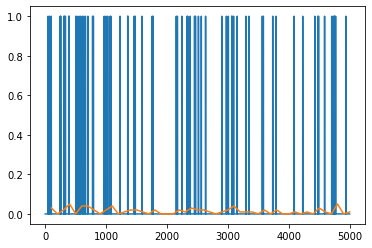

In [53]:
plt.plot(range(0, 5000), es_list)
avg_list = es_list.reshape(50, 100)
avg_list = np.mean(avg_list, axis=1)
x_avg = []
for i in range (0, 50):
    x_avg.append(100 * (i + 1))

plt.plot(x_avg, avg_list)